In [1]:
import sys
from pathlib import Path

# Notebook cell
%load_ext autoreload
%autoreload 2

# Get root directory (assuming notebook is in root/notebooks/)
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'notebooks' else NOTEBOOK_DIR

# Add src directory to Python path
sys.path.append(str(ROOT_DIR / 'src'))

# Verify path
print(f"Python will look in these locations:\n{sys.path}")


# --- Execute the processor ---
import utils
from config import date_str, DOWNLOAD_DIR, DEST_DIR



Python will look in these locations:
['C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9\\python311.zip', 'C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9\\DLLs', 'C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9\\Lib', 'C:\\Users\\ping\\.pyenv\\pyenv-win\\versions\\3.11.9', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv', '', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\ping\\Files_win10\\python\\py311\\.venv\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\ping\\Files_win10\\python\\py311\\stocks\\src']


In [2]:
import pandas as pd
# Set pandas display options to show more columns and rows
pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', 10)       # Limit to 10 rows for readability
pd.set_option('display.width', 1000)        # Let the display adjust to the window
# pd.set_option('display.max_colwidth', None) # Show full content of each cell
pd.set_option('display.max_rows', 200)
# pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.4f}'.format)

In [3]:
zscore_df = pd.read_parquet(f'..\data\{date_str}_zscore_df.parquet', engine='pyarrow')
cluster_stats_df = pd.read_parquet(f'..\data\{date_str}_cluster_stats_df.parquet', engine='pyarrow')
detailed_clusters_df = pd.read_parquet(f'..\data\{date_str}_detailed_clusters_df.parquet', engine='pyarrow')
df_data = pd.read_parquet(f'..\data\{date_str}_df_finviz_merged.parquet', engine='pyarrow')

In [4]:
detailed_clusters_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1189 entries, 484 to 110
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cluster_ID      1189 non-null   int32  
 1   Ticker          1189 non-null   object 
 2   Raw_Score       1189 non-null   float64
 3   Risk_Adj_Score  1189 non-null   float64
 4   Volatility      1189 non-null   float64
 5   Price           1189 non-null   float64
 6   MktCap AUM, M   1189 non-null   float64
dtypes: float64(5), int32(1), object(1)
memory usage: 69.7+ KB


In [5]:
import pandas as pd # Assuming pandas is used

def select_stocks_from_clusters(cluster_stats_df, detailed_clusters_df,
                                num_clusters=3, max_selection_per_cluster=5,
                                min_cluster_size=5, penalty_IntraCluster_Corr=0.3,
                                date_str=date_str,
                                min_raw_score=None, # <-- Added argument
                                min_risk_adj_score=None): # <-- Added argument
    """
    Pipeline to select stocks from better performing clusters, with optional score thresholds.

    Parameters:
    - cluster_stats_df: DataFrame with cluster statistics.
    - detailed_clusters_df: DataFrame with detailed cluster information including
                            'Ticker', 'Cluster_ID', 'Raw_Score', 'Risk_Adj_Score', etc.
    - num_clusters: int, Number of top clusters to select (default=3).
    - max_selection_per_cluster: int, Max number of stocks to select from each cluster (default=5).
    - min_cluster_size: int, Minimum size for a cluster to be considered (default=5).
    - penalty_IntraCluster_Corr: float, Penalty weight for intra-cluster correlation in
                                     composite score (default=0.3).
    - date_str: str, Date string for tracking/parameter storage.
    - min_raw_score: float, optional (default=None)
        Minimum Raw_Score required for a stock to be considered for selection.
        If None, no threshold is applied based on Raw_Score.
    - min_risk_adj_score: float, optional (default=None)
        Minimum Risk_Adj_Score required for a stock to be considered for selection.
        If None, no threshold is applied based on Risk_Adj_Score.

    Returns:
    - dict: A dictionary containing:
        - 'selected_stocks': DataFrame of selected stocks.
        - 'cluster_performance': DataFrame of selected cluster metrics.
        - 'parameters': Dictionary of the input parameters used.
    """

    # Store input parameters
    parameters = {
        'date_str': date_str,
        'num_clusters': num_clusters,
        'max_selection_per_cluster': max_selection_per_cluster,
        'min_cluster_size': min_cluster_size,
        'min_raw_score': min_raw_score,         # <-- Stored parameter
        'min_risk_adj_score': min_risk_adj_score, # <-- Stored parameter
        'penalty_IntraCluster_Corr': penalty_IntraCluster_Corr,
    }

    # ===== 1. Filter and Rank Clusters =====
    qualified_clusters = cluster_stats_df[cluster_stats_df['Size'] >= min_cluster_size].copy()
    if qualified_clusters.empty:
        print(f"Warning: No clusters met the minimum size criteria ({min_cluster_size}).")
        return {
            'selected_stocks': pd.DataFrame(),
            'cluster_performance': pd.DataFrame(),
            'parameters': parameters
        }

    qualified_clusters['Composite_Cluster_Score'] = (
        (1 - penalty_IntraCluster_Corr) * qualified_clusters['Avg_Raw_Score'] +
        penalty_IntraCluster_Corr * (1 - qualified_clusters['Avg_IntraCluster_Corr'])
    )
    ranked_clusters = qualified_clusters.sort_values('Composite_Cluster_Score', ascending=False)
    selected_clusters = ranked_clusters.head(num_clusters)
    cluster_ids = selected_clusters['Cluster_ID'].tolist()

    if not cluster_ids:
        print("Warning: No clusters were selected based on ranking.")
        return {
            'selected_stocks': pd.DataFrame(),
            'cluster_performance': selected_clusters, # Return empty selected clusters df
            'parameters': parameters
        }


    # ===== 2. Select Stocks from Each Cluster =====
    selected_stocks_list = []
    for cluster_id in cluster_ids:
        # Get all stocks for the current cluster
        cluster_stocks = detailed_clusters_df[detailed_clusters_df['Cluster_ID'] == cluster_id].copy()

        # ===> Apply Threshold Filters <===
        if min_raw_score is not None:
            cluster_stocks = cluster_stocks[cluster_stocks['Raw_Score'] >= min_raw_score]
        if min_risk_adj_score is not None:
            cluster_stocks = cluster_stocks[cluster_stocks['Risk_Adj_Score'] >= min_risk_adj_score]
        # ===> End of Added Filters <===

        # Proceed only if stocks remain after filtering
        if len(cluster_stocks) > 0:
            # Sort remaining stocks by Risk_Adj_Score and select top N
            top_stocks = cluster_stocks.sort_values('Risk_Adj_Score', ascending=False).head(max_selection_per_cluster)

            # Add cluster-level metrics to the selected stock rows
            cluster_metrics = selected_clusters[selected_clusters['Cluster_ID'] == cluster_id].iloc[0]
            for col in ['Composite_Cluster_Score', 'Avg_IntraCluster_Corr', 'Avg_Volatility',
                      'Avg_Raw_Score', 'Avg_Risk_Adj_Score', 'Size']: # Added Size for context
                # Use .get() for safety if a column might be missing
                top_stocks[f'Cluster_{col}'] = cluster_metrics.get(col, None)
            selected_stocks_list.append(top_stocks)

    # Consolidate selected stocks
    if selected_stocks_list:
        selected_stocks = pd.concat(selected_stocks_list)
        # Recalculate weights based on the final selection
        if selected_stocks['Risk_Adj_Score'].sum() != 0:
             selected_stocks['Weight'] = (selected_stocks['Risk_Adj_Score'] /
                                          selected_stocks['Risk_Adj_Score'].sum())
        else:
             # Handle case where all selected scores are zero (unlikely but possible)
             selected_stocks['Weight'] = 1 / len(selected_stocks) if len(selected_stocks) > 0 else 0

        selected_stocks = selected_stocks.sort_values(['Cluster_ID', 'Risk_Adj_Score'],
                                                    ascending=[True, False])
    else:
        selected_stocks = pd.DataFrame()
        print("Warning: No stocks met selection criteria (including score thresholds if applied).")


    # ===== 3. Prepare Enhanced Output Reports =====
    cluster_performance = selected_clusters.copy()
    # Calculate how many stocks were actually selected per cluster after filtering
    cluster_performance['Stocks_Selected'] = cluster_performance['Cluster_ID'].apply(
        lambda x: len(selected_stocks[selected_stocks['Cluster_ID'] == x]) if not selected_stocks.empty else 0)

    if not selected_stocks.empty:
         # Ensure Avg_IntraCluster_Corr exists before calculating diversification
        if 'Avg_IntraCluster_Corr' in cluster_performance.columns:
             cluster_performance['Intra_Cluster_Diversification'] = 1 - cluster_performance['Avg_IntraCluster_Corr']
        else:
             cluster_performance['Intra_Cluster_Diversification'] = pd.NA # Or None
    else:
      # Handle case where selected_stocks is empty
        cluster_performance['Intra_Cluster_Diversification'] = pd.NA # Or None

    # ===> Package results and parameters
    results_bundle = {
        'selected_stocks': selected_stocks,
        'cluster_performance': cluster_performance,
        'parameters': parameters
    }

    return results_bundle



In [6]:
import pandas as pd
from typing import Dict, Any

def print_stock_selection_report(output: Dict[str, Any]) -> None:
    """
    Prints a detailed report summarizing the results of the stock selection process,
    extracting all necessary information from the output dictionary.

    Args:
        output (Dict[str, Any]): The dictionary returned by the
                                 select_stocks_from_clusters function, containing:
                                 - 'selected_stocks': DataFrame of selected stocks.
                                 - 'cluster_performance': DataFrame of selected cluster metrics.
                                #  - 'parameters': Dictionary of the input parameters used.
                                #  - 'input_cluster_stats_df': Original cluster stats DataFrame.
                                #  - 'input_detailed_clusters_df': Original detailed clusters DataFrame.
    Returns:
        None: This function prints output to the console.
    """
    # Extract data from the output dictionary using .get() for safety
    selected_stocks = output.get('selected_stocks', pd.DataFrame())
    cluster_performance = output.get('cluster_performance', pd.DataFrame())
    used_params = output.get('parameters', {})
    # Extract the input DataFrames needed for the report
    cluster_stats_df = output.get('input_cluster_stats_df') # Might be None
    detailed_clusters_df = output.get('input_detailed_clusters_df') # Might be None

    # --- Start of Original Code Block (adapted) ---

    print("\n=== CLUSTER SELECTION CRITERIA ===")
    print("* Using Composite_Cluster_Score (balancing Raw Score and diversification) for cluster ranking.")
    print("* Using Risk_Adj_Score for stock selection within clusters.")

    num_selected_clusters = len(cluster_performance) if not cluster_performance.empty else 0
    # Use the extracted cluster_stats_df
    total_clusters = len(cluster_stats_df) if cluster_stats_df is not None and not cluster_stats_df.empty else 'N/A'

    print(f"* Selected top {num_selected_clusters} clusters from {total_clusters} total initial clusters.") # Adjusted wording slightly
    print(f"* Selection Criteria:")
    if used_params:
        for key, value in used_params.items():
            # Avoid printing the large input dataframes stored in parameters if they were added there too
            if not isinstance(value, pd.DataFrame):
                 print(f"    {key}: {value}")
    else:
        print("    Parameters not available.")


    if not cluster_performance.empty:
        print("\n=== SELECTED CLUSTERS (RANKED BY COMPOSITE SCORE) ===")
        display_cols_exist = [col for col in [
                                'Cluster_ID', 'Size', 'Avg_Raw_Score', 'Avg_Risk_Adj_Score',
                                'Avg_IntraCluster_Corr', 'Avg_Volatility', 'Composite_Cluster_Score',
                                'Stocks_Selected', 'Intra_Cluster_Diversification']
                              if col in cluster_performance.columns]
        print(cluster_performance[display_cols_exist].sort_values('Composite_Cluster_Score', ascending=False).to_string(index=False))

        # Print top 8 stocks by Raw_Score for each selected cluster
        # Check if detailed_clusters_df was successfully extracted
        if detailed_clusters_df is not None and not detailed_clusters_df.empty:
            print("\n=== TOP STOCKS BY RAW SCORE PER SELECTED CLUSTER ===")
            print("""* Volatility is the standard deviation of daily returns over the past 250 trading days (example context).
* Note: The stocks below are shown ranked by Raw_Score for analysis,
*       but actual selection within the cluster was based on Risk_Adj_Score.""")

            for cluster_id in cluster_performance['Cluster_ID']:
                 cluster_stocks = detailed_clusters_df[detailed_clusters_df['Cluster_ID'] == cluster_id]
                 if not cluster_stocks.empty:
                    required_cols = ['Ticker', 'Raw_Score', 'Risk_Adj_Score', 'Volatility']
                    if all(col in cluster_stocks.columns for col in required_cols):
                        top_raw = cluster_stocks.nlargest(8, 'Raw_Score')[required_cols]

                        print(f"\nCluster {cluster_id} - Top 8 by Raw Score:")
                        print(top_raw.to_string(index=False))
                        cluster_avg_raw = cluster_performance.loc[cluster_performance['Cluster_ID'] == cluster_id, 'Avg_Raw_Score'].values
                        cluster_avg_risk = cluster_performance.loc[cluster_performance['Cluster_ID'] == cluster_id, 'Avg_Risk_Adj_Score'].values
                        if len(cluster_avg_raw) > 0: print(f"Cluster Avg Raw Score: {cluster_avg_raw[0]:.2f}")
                        if len(cluster_avg_risk) > 0: print(f"Cluster Avg Risk Adj Score: {cluster_avg_risk[0]:.2f}")
                    else:
                        print(f"\nCluster {cluster_id} - Missing required columns in detailed_clusters_df to show top stocks.")
                 else:
                     print(f"\nCluster {cluster_id} - No stocks found in detailed_clusters_df for this cluster.")
        else:
            print("\n=== TOP STOCKS BY RAW SCORE PER SELECTED CLUSTER ===")
            print("Skipping - Detailed cluster information ('input_detailed_clusters_df') not found in the output dictionary.")

    else:
        print("\n=== SELECTED CLUSTERS ===")
        print("No clusters were selected based on the criteria.")


    print(f"\n=== FINAL SELECTED STOCKS (FILTERED & WEIGHTED) ===")
    if not selected_stocks.empty:
        print("* Stocks actually selected based on Risk_Adj_Score (and optional thresholds) within each cluster.")
        print("* Position weights assigned based on Risk_Adj_Score within the final selected portfolio.")

        desired_cols = ['Cluster_ID', 'Ticker', 'Raw_Score', 'Risk_Adj_Score',
                        'Volatility', 'Weight',
                        'Cluster_Avg_Raw_Score', 'Cluster_Avg_Risk_Adj_Score']
        available_cols = [col for col in desired_cols if col in selected_stocks.columns]
        print(selected_stocks[available_cols].sort_values(['Cluster_ID', 'Risk_Adj_Score'],
                                                        ascending=[True, False]).to_string(index=False))

        print("\n=== PORTFOLIO SUMMARY ===")
        print(f"Total Stocks Selected: {len(selected_stocks)}")
        print(f"Average Raw Score: {selected_stocks.get('Raw_Score', pd.Series(dtype=float)).mean():.2f}")
        print(f"Average Risk-Adjusted Score: {selected_stocks.get('Risk_Adj_Score', pd.Series(dtype=float)).mean():.2f}")
        print(f"Average Volatility: {selected_stocks.get('Volatility', pd.Series(dtype=float)).mean():.2f}")
        print(f"Total Weight (should be close to 1.0): {selected_stocks.get('Weight', pd.Series(dtype=float)).sum():.4f}")
        print("\nCluster Distribution:")
        print(selected_stocks['Cluster_ID'].value_counts().to_string())
    else:
        print("No stocks were selected after applying all filters and criteria.")


In [7]:
raw_score_scale_factor = 0.8
risk_adj_score_scale_factor = 0.8

num_clusters = 1000
max_selection_per_cluster = 2
min_cluster_size = 3  # prevent extreme high risk adj scores 
min_raw_score = 2.0 * raw_score_scale_factor    
min_risk_adj_score = 100.0  * risk_adj_score_scale_factor
penalty_IntraCluster_Corr = 0

# # Default values
# num_clusters = 3
# max_selection_per_cluster = 5
# min_cluster_size = 5
# penalty_IntraCluster_Corr = 0.3
# min_raw_score = None      
# min_risk_adj_score = None  

# Run the selection pipeline
output = select_stocks_from_clusters(
    cluster_stats_df=cluster_stats_df,
    detailed_clusters_df=detailed_clusters_df,
    num_clusters=num_clusters,
    max_selection_per_cluster=max_selection_per_cluster,
    min_cluster_size=min_cluster_size,
    penalty_IntraCluster_Corr=penalty_IntraCluster_Corr,
    min_raw_score=min_raw_score,      # Example threshold
    min_risk_adj_score=min_risk_adj_score  # Example threshold    
)



In [8]:
print(output['parameters']['date_str'])
print(output['parameters']['min_raw_score'])
print(output['parameters']['min_risk_adj_score'])
print(output['selected_stocks'].info())

2025-04-10
1.6
80.0
<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 24 to 11
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Cluster_ID                       5 non-null      int32  
 1   Ticker                           5 non-null      object 
 2   Raw_Score                        5 non-null      float64
 3   Risk_Adj_Score                   5 non-null      float64
 4   Volatility                       5 non-null      float64
 5   Price                            5 non-null      float64
 6   MktCap AUM, M                    5 non-null      float64
 7   Cluster_Composite_Cluster_Score  5 non-null      float64
 8   Cluster_Avg_IntraCluster_Corr    5 non-null      float64
 9   Cluster_Avg_Volatility           5 non-null      float64
 10  Cluster_Avg_Raw_Score            5 non-null      float64
 11  Cluster_Avg_Risk_Adj_Score       5 non-null      float64
 12  Cluster_S

In [9]:
print_stock_selection_report(output)


=== CLUSTER SELECTION CRITERIA ===
* Using Composite_Cluster_Score (balancing Raw Score and diversification) for cluster ranking.
* Using Risk_Adj_Score for stock selection within clusters.
* Selected top 42 clusters from N/A total initial clusters.
* Selection Criteria:
    date_str: 2025-04-10
    num_clusters: 1000
    max_selection_per_cluster: 2
    min_cluster_size: 3
    min_raw_score: 1.6
    min_risk_adj_score: 80.0
    penalty_IntraCluster_Corr: 0

=== SELECTED CLUSTERS (RANKED BY COMPOSITE SCORE) ===
 Cluster_ID  Size  Avg_Raw_Score  Avg_Risk_Adj_Score  Avg_IntraCluster_Corr  Avg_Volatility  Composite_Cluster_Score  Stocks_Selected  Intra_Cluster_Diversification
         54    21         1.9813             84.3875                 0.8456          0.0296                   1.9813                2                         0.1544
         44     6         0.8945             35.3119                 0.7648          0.0269                   0.8945                0                   

In [10]:
selected_stocks = output['selected_stocks']
selected_cluster_ids = selected_stocks['Cluster_ID'].unique()

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np

def plot_cluster_statistics(cluster_stats_df, selected_cluster_ids, highlight_color='green', figsize=(12, 16)):
    """
    Generates and displays a 5-panel plot visualizing various cluster statistics.

    Args:
        cluster_stats_df (pd.DataFrame): DataFrame containing cluster statistics.
                                         Must include columns: 'Cluster_ID',
                                         'Avg_Risk_Adj_Score', 'Avg_Raw_Score',
                                         'Avg_IntraCluster_Corr', 'Avg_Volatility', 'Size'.
        selected_cluster_ids (list or set): A collection of Cluster_IDs to highlight
                                            on the plots.
        highlight_color (str, optional): The color used to highlight the bars
                                         corresponding to selected_cluster_ids.
                                         Defaults to 'green'.
        figsize (tuple, optional): The figure size for the plot.
                                   Defaults to (12, 16).
    """
    # Ensure Cluster_ID is suitable for indexing/lookup if it's not already
    # (e.g., if it came from clustering that starts at 1 instead of 0)
    # This assumes cluster IDs are sequential integers starting near 0.
    cluster_ids = cluster_stats_df['Cluster_ID'].values

    # --- Define constants and styles inside the function ---
    HIGHLIGHT_COLOR = highlight_color
    major_grid_style = {'color': 'lightgray', 'linestyle': '--', 'linewidth': 0.6}
    minor_x_grid_style = {'color': 'gray', 'linestyle': '-', 'linewidth': 0.8}

    # --- Define nested helper functions ---
    def create_bars(ax, x, y, color, highlight_ids):
        """Creates bars, highlighting specific IDs."""
        # Ensure highlight_ids is a set for efficient lookup
        highlight_set = set(highlight_ids)
        bar_colors = [HIGHLIGHT_COLOR if cl_id in highlight_set else color for cl_id in x]
        bars = ax.bar(x, y, color=bar_colors, width=0.8)
        return bars

    def configure_axis(ax, title, ylabel, show_xlabel=True):
        """Applies common configuration to an axis."""
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        if show_xlabel:
             ax.set_xlabel('Cluster_ID')

        # Gridlines
        ax.yaxis.grid(True, **major_grid_style)
        ax.xaxis.grid(True, which='major', **major_grid_style)
        ax.xaxis.set_minor_locator(mticker.MultipleLocator(5))
        ax.xaxis.grid(True, which='minor', **minor_x_grid_style)
        ax.tick_params(axis='x', which='minor', bottom=False)

    # --- Create Figure and Axes ---
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=figsize)
    fig.suptitle('Cluster Statistics Analysis', fontsize=16)

    # --- Plotting ---

    # Plot 1: Average Risk-Adjusted Score
    create_bars(ax1, cluster_ids, cluster_stats_df['Avg_Risk_Adj_Score'],
                'skyblue', selected_cluster_ids)
    configure_axis(ax1, 'Average Risk-Adjusted Scores by Cluster', 'Average Risk-Adj Score')

    # Plot 2: Average Raw Score
    create_bars(ax2, cluster_ids, cluster_stats_df['Avg_Raw_Score'],
                'lightgreen', selected_cluster_ids)
    configure_axis(ax2, 'Average Raw Scores by Cluster', 'Average Raw Score')

    # Plot 3: Average Correlation
    create_bars(ax3, cluster_ids, cluster_stats_df['Avg_IntraCluster_Corr'],
                'salmon', selected_cluster_ids)
    configure_axis(ax3, 'Average Intra-Cluster Correlation', 'Average Correlation')

    # Plot 4: Average Volatility
    create_bars(ax4, cluster_ids, cluster_stats_df['Avg_Volatility'],
                'gold', selected_cluster_ids)
    configure_axis(ax4, 'Average Intra-Cluster Volatility', 'Average Volatility')

    # Plot 5: Cluster Size
    create_bars(ax5, cluster_ids, cluster_stats_df['Size'],
                'orchid', selected_cluster_ids)
    configure_axis(ax5, 'Cluster Sizes', 'Number of Members')

    # --- Final Adjustments ---
    num_clusters = len(cluster_ids)
    # Adjust major ticks based on number of clusters for better readability
    if num_clusters <= 20:
        tick_step = 2
    elif num_clusters <= 50:
        tick_step = 5
    else:
        tick_step = 10 # Default for 60+

    major_ticks = np.arange(min(cluster_ids), max(cluster_ids) + 1, tick_step)

    # Apply x-axis limits and consistent major ticks to all axes
    min_id = min(cluster_ids)
    max_id = max(cluster_ids)
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.set_xlim(min_id - 0.5, max_id + 0.5)
        ax.set_xticks(major_ticks)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust rect for suptitle

    plt.show()


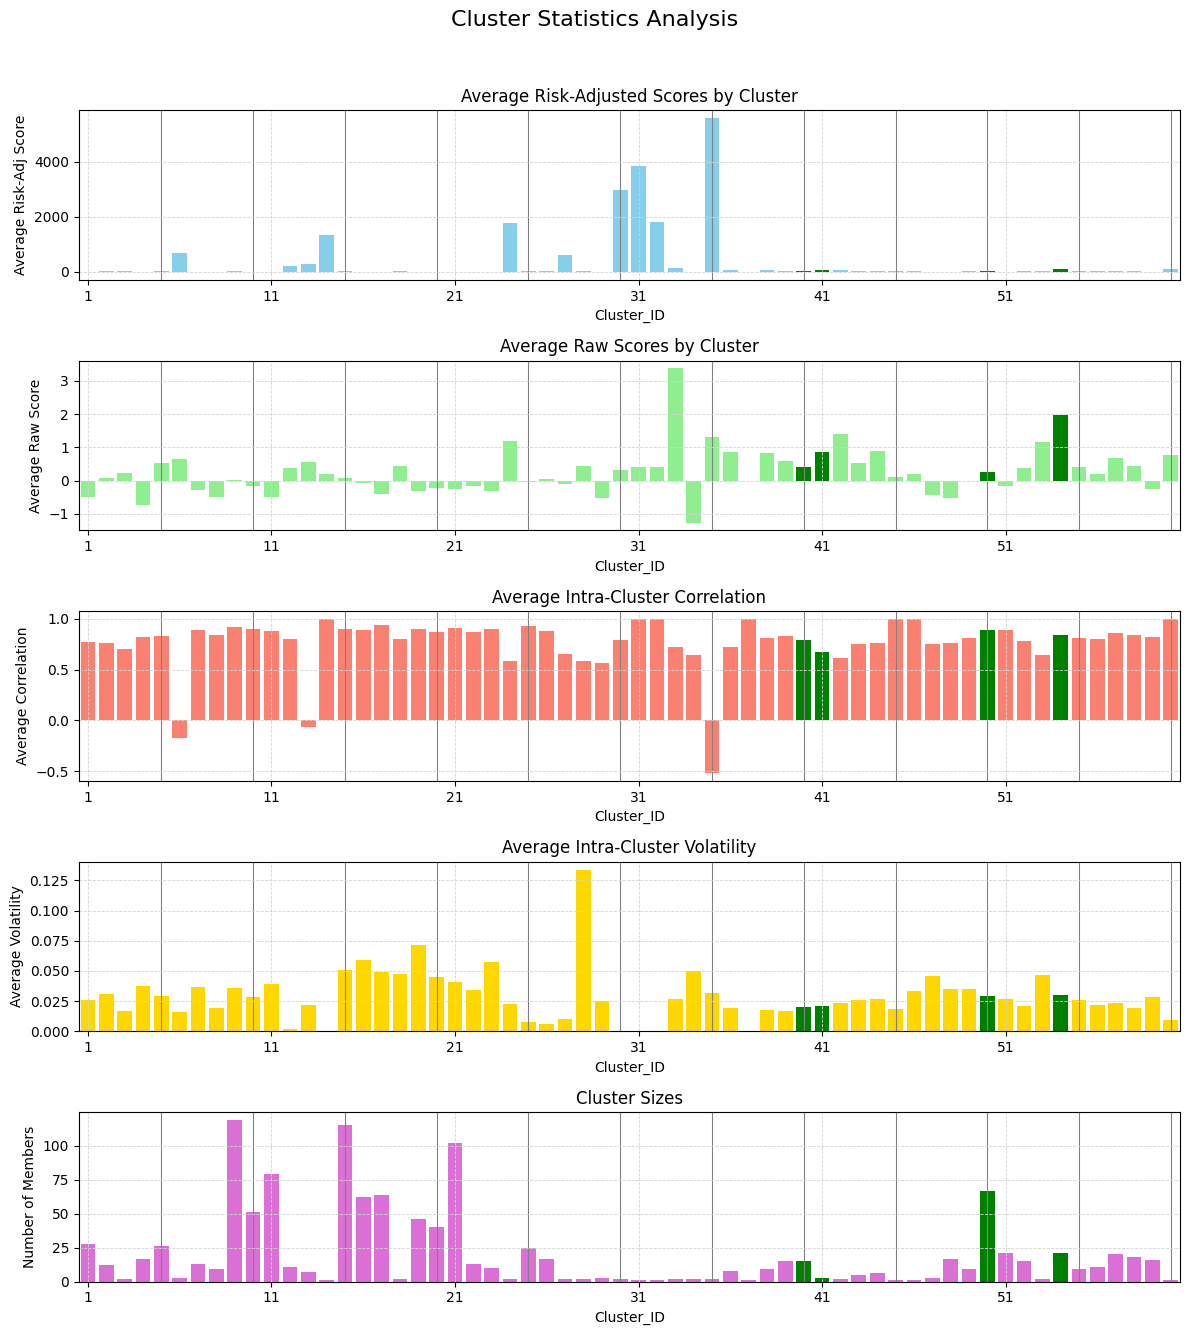

In [12]:
plot_cluster_statistics(cluster_stats_df, selected_cluster_ids, highlight_color='green', figsize=(12, 14))

# You can also change the highlight color or figure size:
# plot_cluster_statistics(cluster_stats_df, final_cluster_ids, highlight_color='red', figsize=(10, 14))

In [13]:
selected_stocks

,Cluster_ID,Ticker,Raw_Score,Risk_Adj_Score,Volatility,Price,"MktCap AUM, M",Cluster_Composite_Cluster_Score,Cluster_Avg_IntraCluster_Corr,Cluster_Avg_Volatility,Cluster_Avg_Raw_Score,Cluster_Avg_Risk_Adj_Score,Cluster_Size,Weight
24,40,HRB,1.6987,95.4367,0.0178,57.0700,7640.0000,0.3994,0.7958,0.0200,0.3994,21.8070,15.0000,0.1645
8,41,PPC,2.3814,108.5041,0.0219,51.5300,12230.0000,0.8712,0.6763,0.0210,0.8712,41.1321,3.0000,0.1871
23,50,TJX,1.7675,90.0429,0.0196,127.4700,142400.0000,0.2685,0.8872,0.0292,0.2685,10.0593,67.0000,0.1552
10,54,SGOL,2.1348,143.0964,0.0149,30.2600,4700.0000,1.9813,0.8456,0.0296,1.9813,84.3875,21.0000,0.2467
11,54,GLDM,2.1342,142.9425,0.0149,62.8000,12990.0000,1.9813,0.8456,0.0296,1.9813,84.3875,21.0000,0.2464


In [14]:
sorted_selected_stocks_df = selected_stocks[['Cluster_ID', 'Ticker', 'Raw_Score', 'Risk_Adj_Score', 'Weight', 'Volatility']] \
              .sort_values(['Weight', 'Cluster_ID'], ascending=[False, False]) \
              .set_index('Ticker')

In [17]:
ticker_order = sorted_selected_stocks_df.index.tolist()

In [18]:
final_selected_stocks = pd.concat([sorted_selected_stocks_df, df_data.loc[ticker_order]], axis=1)
print(final_selected_stocks)

        Cluster_ID  Raw_Score  Risk_Adj_Score  Weight  Volatility                         Company                                               Info  MktCap AUM, M   Beta     RSI  Perf YTD %  Perf 3D %  Perf Week %  Perf Month %  Perf Quart %  Perf Half %  Perf Year %  SMA20 %  SMA50 %  SMA200 %  50D High %  50D Low %  52W High %  52W Low %  All-Time High %  All-Time Low %    ATR  ATR/Price %  Volatility W %  Volatility M %  Volume, M  Avg Volume, M  Rel Volume    Price  Change %  Dividend %  Sharpe 3d  Sortino 3d  Omega 3d  Sharpe 5d  Sortino 5d  Omega 5d  Sharpe 10d  Sortino 10d  Omega 10d  Sharpe 15d  Sortino 15d  Omega 15d  Sharpe 30d  Sortino 30d  Omega 30d  Sharpe 60d  Sortino 60d  Omega 60d  Sharpe 120d  Sortino 120d  Omega 120d  Sharpe 250d  Sortino 250d  Omega 250d
Ticker                                                                                                                                                                                                                 

In [19]:
final_cluster_ids = final_selected_stocks['Cluster_ID'].unique().tolist()

In [20]:
output_filename_tsv = f"..\picks\{date_str}_selected_stocks.tsv"

final_selected_stocks.to_csv(output_filename_tsv, sep='\t', encoding='utf-8', index=True)

In [21]:
final_selected_stocks.to_parquet(f'..\picks\{date_str}_selected_stocks.parquet', engine='pyarrow', compression='zstd')
cluster_stats_df.to_parquet(f'..\picks\{date_str}_cluster_stats_df.parquet', engine='pyarrow', compression='zstd')

In [22]:
# Calculate summary statistics for cluster_stats_df
stats_summary = pd.DataFrame({
    'Count': cluster_stats_df.count(numeric_only=True),
    'Sum': cluster_stats_df.sum(numeric_only=True),
    'Mean': cluster_stats_df.mean(numeric_only=True),
    'Std': cluster_stats_df.std(numeric_only=True),
    'Mean+1Std (68%)': cluster_stats_df.mean(numeric_only=True) + cluster_stats_df.std(numeric_only=True),
    'Mean-1Std (68%)': cluster_stats_df.mean(numeric_only=True) - cluster_stats_df.std(numeric_only=True),
    'Mean+2Std (95%)': cluster_stats_df.mean(numeric_only=True) + 2*cluster_stats_df.std(numeric_only=True),
    'Mean-2Std (95%)': cluster_stats_df.mean(numeric_only=True) - 2*cluster_stats_df.std(numeric_only=True),
    'Min': cluster_stats_df.min(numeric_only=True),
    'Max': cluster_stats_df.max(numeric_only=True),
})

print("Summary Statistics for Cluster Data:")
display(stats_summary.round(4))

Summary Statistics for Cluster Data:


,Count,Sum,Mean,Std,Mean+1Std (68%),Mean-1Std (68%),Mean+2Std (95%),Mean-2Std (95%),Min,Max
Cluster_ID,60,1830.0000,30.5000,17.4642,47.9642,13.0358,65.4285,-4.4285,1.0000,60.0000
Size,60,1189.0000,19.8167,27.9567,47.7733,-8.1400,75.7300,-36.0967,1.0000,119.0000
Avg_IntraCluster_Corr,60,46.2122,0.7702,0.2641,1.0344,0.5061,1.2985,0.2419,-0.5173,1.0000
Avg_Raw_Score,60,15.9528,0.2659,0.7065,0.9724,-0.4406,1.6789,-1.1471,-1.2616,3.3738
Avg_Risk_Adj_Score,60,19693.4309,328.2238,985.4021,1313.6260,-657.1783,2299.0281,-1642.5804,-27.4355,5586.4137
Avg_Volatility,60,1.7251,0.0288,0.0208,0.0496,0.0079,0.0704,-0.0129,0.0001,0.1340


In [23]:
# Sort by Avg_Raw_Score in descending order
sorted_by_Avg_Raw_Score = cluster_stats_df.sort_values('Avg_Raw_Score', ascending=False)
print(f'sorted_by_Avg_Raw_Score')
display(sorted_by_Avg_Raw_Score.head(10))

sorted_by_Avg_Raw_Score


,Cluster_ID,Size,Avg_IntraCluster_Corr,Avg_Raw_Score,Avg_Risk_Adj_Score,Avg_Volatility
32,33,2,0.7276,3.3738,134.1458,0.0266
53,54,21,0.8456,1.9813,84.3875,0.0296
41,42,2,0.6159,1.3897,62.0238,0.0232
34,35,2,-0.5173,1.3245,5586.4137,0.0314
23,24,2,0.5873,1.1915,1772.7512,0.0222
52,53,2,0.6470,1.1545,26.9540,0.0464
43,44,6,0.7648,0.8945,35.3119,0.0269
40,41,3,0.6763,0.8712,41.1321,0.0210
35,36,8,0.7193,0.8647,46.2177,0.0190
37,38,9,0.8067,0.8349,48.4492,0.0176


In [24]:
print(f"\nVariance for 'GLD' = df_cov.loc['GLD', 'GLD']")
print(f"volatility for 'GLD' = df_cov.loc['GLD', 'GLD']**0.5")


Variance for 'GLD' = df_cov.loc['GLD', 'GLD']
volatility for 'GLD' = df_cov.loc['GLD', 'GLD']**0.5


In [25]:
pd.set_option('display.max_rows', 200)

print(f"Variance for 'GLD' = df_cov.loc['GLD', 'GLD']")
print(f"volatility for 'GLD' = df_cov.loc['GLD', 'GLD']**0.5")
print(f"\nUse sorted_df_desc.head(200) to prevent truncation and see the top 200 rows")

sorted_df_desc = detailed_clusters_df.sort_values(by='Risk_Adj_Score', ascending=False)
print(sorted_df_desc.head(200))

Variance for 'GLD' = df_cov.loc['GLD', 'GLD']
volatility for 'GLD' = df_cov.loc['GLD', 'GLD']**0.5

Use sorted_df_desc.head(200) to prevent truncation and see the top 200 rows
     Cluster_ID Ticker  Raw_Score  Risk_Adj_Score  Volatility    Price  MktCap AUM, M
27           35   USFR     1.5867      11155.8783      0.0001  50.3700     18800.0000
221          31   SGOV     0.4124       3824.2041      0.0001 100.4400     42140.0000
247          30    BIL     0.3555       3533.3979      0.0001  91.5200     46560.0000
167          24   TBIL     0.5633       3504.4534      0.0002  49.8900      5370.0000
267          30    SHV     0.2986       2408.3857      0.0001 110.2200     20750.0000
231           6   GBIL     0.3932       1924.7733      0.0002  99.9600      6340.0000
214          32   BOXX     0.4232       1797.8729      0.0002 111.6000      5770.0000
352          14   TFLO     0.1884       1315.2648      0.0001  50.5200      7050.0000
210          27   ICSH     0.4311       1266.3201 

In [26]:
pd.set_option('display.max_rows', 200)

print(detailed_clusters_df)

      Cluster_ID Ticker  Raw_Score  Risk_Adj_Score  Volatility    Price  MktCap AUM, M
484            1   VUSB     0.0481         48.7273      0.0010  49.5000      4950.0000
339            1   FLOT     0.2009         41.6779      0.0048  50.3100      8790.0000
323            1    ABT     0.2170         11.5432      0.0188 124.5000    215920.0000
470            1     EW     0.0590          2.7924      0.0211  68.2600     39980.0000
483            1    RDY     0.0486          2.0549      0.0237  12.7100     10590.0000
...          ...    ...        ...             ...         ...      ...            ...
1063          59     CF    -0.6565        -24.1136      0.0272  69.9700     11650.0000
1019          59    PBA    -0.5704        -24.4135      0.0234  35.1600     20410.0000
1155          59   BMRN    -1.0417        -27.9462      0.0373  56.3600     10750.0000
1126          59    EPD    -0.8836        -39.7523      0.0222  28.9500     62700.0000
110           60   BECN     0.7835         

In [27]:
# Step 1: Drop Tickers 
drop_tickers = ['BECN']
selected_stocks = selected_stocks[~selected_stocks['Ticker'].isin(drop_tickers)].copy()

# Step 1: Drop Cluster 
drop_cluster = 0
selected_stocks = selected_stocks[selected_stocks['Cluster_ID'] != drop_cluster].copy()

# Step 2: Recalculate weights based on remaining stocks' Risk_Adj_Scores
selected_stocks['Weight'] = selected_stocks['Risk_Adj_Score'] / selected_stocks['Risk_Adj_Score'].sum()

# Step 3: Display the updated portfolio
print(f"\n=== UPDATED PORTFOLIO (CLUSTER {drop_cluster}, TICKER {drop_tickers} REMOVED) ===")
# sorted_selected_stocks_df = selected_stocks[['Cluster_ID', 'Ticker', 'Raw_Score', 'Risk_Adj_Score', 'Weight', 'Volatility']] \
#               .sort_values(['Weight', 'Cluster_ID'], ascending=[False, False])
# Select columns, sort, and then set 'Ticker' as the index
sorted_selected_stocks_df = selected_stocks[['Cluster_ID', 'Ticker', 'Raw_Score', 'Risk_Adj_Score', 'Weight', 'Volatility']] \
              .sort_values(['Weight', 'Cluster_ID'], ascending=[False, False]) \
              .set_index('Ticker')



print(sorted_selected_stocks_df.to_string(index=True))

# Step 4: Extract the 'Ticker' column from the sorted DataFrame
ticker_order = sorted_selected_stocks_df.index.tolist()


# Optional: Print weight redistribution summary
original_total = 1.0
new_total = selected_stocks['Weight'].sum()
print(f"\nWeights redistributed from Cluster {drop_cluster} & Ticker {drop_tickers}: {original_total - new_total:.1%}")
print(f"New total weights sum to: {new_total:.0%}")


=== UPDATED PORTFOLIO (CLUSTER 0, TICKER ['BECN'] REMOVED) ===
        Cluster_ID  Raw_Score  Risk_Adj_Score  Weight  Volatility
Ticker                                                           
SGOL            54     2.1348        143.0964  0.2467      0.0149
GLDM            54     2.1342        142.9425  0.2464      0.0149
PPC             41     2.3814        108.5041  0.1871      0.0219
HRB             40     1.6987         95.4367  0.1645      0.0178
TJX             50     1.7675         90.0429  0.1552      0.0196

Weights redistributed from Cluster 0 & Ticker ['BECN']: 0.0%
New total weights sum to: 100%
